In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
df = pd.read_csv(r"E:\internship WPPOOL\wppool_cleaned_growth_data_sample_20k.csv")
df

,user_id,install_date,last_active_date,subscription_type,country,total_sessions,page_views,download_clicks,activation_status,days_active,pro_upgrade_date,plan_type,monthly_revenue,churned
0,1,2023-06-29,2023-07-12,Free,UK,3,15,1,1,13,NaN,NaN,0,1
1,2,2023-04-10,2023-07-25,Free,India,133,665,0,1,106,NaN,NaN,0,0
2,3,2023-10-25,2023-12-07,Free,USA,53,106,0,1,43,NaN,NaN,0,0
3,4,2023-08-26,2023-11-09,Pro,Canada,242,242,0,1,75,2023-11-09,Basic,49,0
4,5,2023-05-14,2023-11-22,Free,UK,12,48,0,1,192,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-05-20,2023-12-19,Free,India,142,284,1,1,213,NaN,NaN,0,0
996,997,2023-11-03,2023-12-25,Free,Germany,11,44,0,1,52,NaN,NaN,0,0
997,998,2023-10-26,2023-11-16,Free,Canada,94,376,0,1,21,NaN,NaN,0,1
998,999,2023-05-10,2023-06-28,Free,Germany,4,20,0,1,49,NaN,NaN,0,0


In [2]:
## top 3 factors contributing to churn using correlation or regression analysis.
## using correlation
correlation_matrix = df.corr(numeric_only=True)

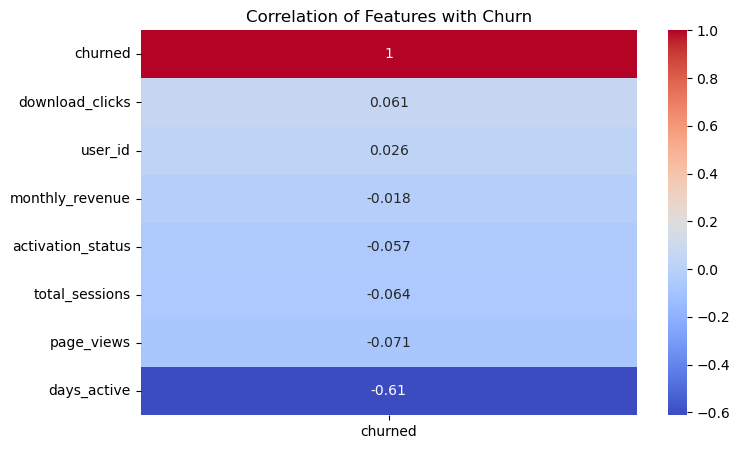

In [3]:
## correlation with churn
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix[['churned']].sort_values(by='churned', ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Churn")
plt.show()

In [4]:
## Top 3 correlated features
top_factors = correlation_matrix['churned'].drop('churned').abs().sort_values(ascending=False).head(3)
print("Top 3 Factors Contributing to Churn:")
print(top_factors)

Top 3 Factors Contributing to Churn:
days_active       0.612409
page_views        0.071108
total_sessions    0.064425
Name: churned, dtype: float64


In [5]:
#churn trends between free and pro users
churn_trends = df.groupby("subscription_type")["churned"].agg(["count", "sum"])
churn_trends["churn_rate"] = (churn_trends["sum"] / churn_trends["count"]) * 100
print("\nChurn Trends by Subscription Type:")
print(churn_trends.sort_values(by="churn_rate", ascending=False))


Churn Trends by Subscription Type:
                   count  sum  churn_rate
subscription_type                        
Free                 824  234   28.398058
Pro                  176   37   21.022727


In [6]:
## Revenue & Upgrade Trends
## Percentage of users upgraded from Free to Pro

## count of total users who started as free
total_free_users = df[df["subscription_type"] == "Free"].shape[0]

## count of users who upgraded
upgraded_users = df[df["pro_upgrade_date"].notna()].shape[0]

## upgrade percentage
upgrade_percentage = (upgraded_users / total_free_users) * 100 if total_free_users > 0 else 0
print(f"Percentage of users who upgraded from Free to Pro: {upgrade_percentage:.2f}%")

Percentage of users who upgraded from Free to Pro: 21.36%


In [7]:
##Calculate the total monthly revenue from Pro users
total_monthly_revenue = df[df["subscription_type"] == "Pro"]["monthly_revenue"].sum()
print(f"Total monthly revenue from Pro users: ${total_monthly_revenue:2f}")

Total monthly revenue from Pro users: $9924.000000


In [8]:
# Calculate revenue by Pro plan type
pro_revenue_by_plan = df[df["subscription_type"] == "Pro"].groupby("plan_type")["monthly_revenue"].sum()

# Identify the most profitable plan
most_profitable_plan = pro_revenue_by_plan.idxmax()
most_profitable_revenue = pro_revenue_by_plan.max()

# Print revenue for all Pro plan types
print("Revenue contribution by Pro plan type:")
print(pro_revenue_by_plan.to_string())

# Highlight the most profitable plan
print(f"\nThe Pro plan contributing the most revenue is {most_profitable_plan} with ${most_profitable_revenue:.2f}")


Revenue contribution by Pro plan type:
plan_type
Basic         2918
Enterprise    3580
Standard      3426

The Pro plan contributing the most revenue is Enterprise with $3580.00


In [11]:
# Analyze upgrade time based on country and engagement level
df["install_date"] = pd.to_datetime(df["install_date"])
df["pro_upgrade_date"] = pd.to_datetime(df["pro_upgrade_date"])
df["upgrade_time"] = (df["pro_upgrade_date"] - df["install_date"]).dt.days

# Group by country and calculate average upgrade time (rounded)
upgrade_time_by_country = (
    df[df["upgrade_time"].notna()]
    .groupby("country", observed=False)["upgrade_time"]
    .mean()
    .round(0)
    .astype(int)
    .sort_values()
)

# Group by engagement level (e.g., total_sessions) and calculate average upgrade time (rounded)
engagement_bins = pd.qcut(df["total_sessions"], q=4, labels=["Low", "Medium", "High", "Very High"])
df["engagement_level"] = engagement_bins
upgrade_time_by_engagement = (
    df[df["upgrade_time"].notna()]
    .groupby("engagement_level", observed=False)["upgrade_time"]
    .mean()
    .round(0)
    .astype(int)
    .sort_values()
)

print("\nAverage upgrade time by country:")
print(upgrade_time_by_country)
print("\nAverage upgrade time by engagement level:")
print(upgrade_time_by_engagement)



Average upgrade time by country:
country
UK            68
Australia     81
France        92
Germany       93
India         99
Canada       112
USA          117
Name: upgrade_time, dtype: int32

Average upgrade time by engagement level:
engagement_level
Medium        86
High          98
Very High     99
Low          101
Name: upgrade_time, dtype: int32


In [18]:
## If WPPOOL increases the landing page conversion rate by 10%, what would be the estimated impact on Pro upgrades?
def estimate_pro_upgrades(visitor_count, landing_conversion_rate, upgrade_rate, increase_percent=10):
   
    # Current number of Free users per month
    current_free_users = visitor_count * landing_conversion_rate
    
    # New conversion rate after increase
    new_conversion_rate = landing_conversion_rate * (1 + increase_percent / 100)
    
    # New Free users per month
    new_free_users = visitor_count * new_conversion_rate
    
    # Current and new Pro upgrades
    current_pro_upgrades = current_free_users * upgrade_rate
    new_pro_upgrades = new_free_users * upgrade_rate
    
    # Increase in Pro upgrades
    pro_upgrade_increase = new_pro_upgrades - current_pro_upgrades
    
    return {
        "Current Free Users": round(current_free_users),
        "New Free Users": round(new_free_users),
        "Current Pro Upgrades": round(current_pro_upgrades),
        "New Pro Upgrades": round(new_pro_upgrades),
        "Increase in Pro Upgrades": round(pro_upgrade_increase)
    }

# Example usage
visitor_count = 100000  # Monthly visitors
landing_conversion_rate = 0.05  # 5% conversion rate
upgrade_rate = 0.08  # 8% Free-to-Pro conversion rate
increase_percent = 10  # 10% boost in landing page conversion rate

impact = estimate_pro_upgrades(visitor_count, landing_conversion_rate, upgrade_rate, increase_percent)
print(impact)

{'Current Free Users': 5000, 'New Free Users': 5500, 'Current Pro Upgrades': 400, 'New Pro Upgrades': 440, 'Increase in Pro Upgrades': 40}


In [21]:
##Run a simple A/B test simulation (e.g., using a chi-square test) to evaluate conversion optimization.
def run_ab_test(control_conversions, control_visitors, test_conversions, test_visitors):
    """
    Perform a chi-square test to evaluate A/B test results.
    
    :param control_conversions: Number of conversions in control group
    :param control_visitors: Number of visitors in control group
    :param test_conversions: Number of conversions in test group
    :param test_visitors: Number of visitors in test group
    :return: p-value from the chi-square test
    """
    # Create a contingency table
    contingency_table = [[control_conversions, control_visitors - control_conversions],
                         [test_conversions, test_visitors - test_conversions]]
    
    # Perform chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    return {
        "Chi-Square Statistic": chi2,
        "P-Value": p,
        "Degrees of Freedom": dof,
        "Expected Frequencies": expected
    }
# Example A/B test scenario
control_conversions = 2500
control_visitors = 50000

test_conversions = 2800
test_visitors = 50000

ab_test_results = run_ab_test(control_conversions, control_visitors, test_conversions, test_visitors)
print(ab_test_results)

{'Chi-Square Statistic': 17.812157558127954, 'P-Value': 2.438203400902426e-05, 'Degrees of Freedom': 1, 'Expected Frequencies': array([[ 2650., 47350.],
       [ 2650., 47350.]])}


In [23]:
# 3 KPIs to track 1. Churn_rate
# Count total Pro users
total_pro_users = df[df["subscription_type"] == "Pro"].shape[0]

# Count churned Pro users using the 'churned' column
if "churned" in df.columns:
    churned_users = df[(df["subscription_type"] == "Pro") & (df["churned"] == 1)].shape[0]
else:
    churned_users = 0  # Default to 0 if column is missing

# Calculate churn rate
churn_rate = (churned_users / total_pro_users) * 100 if total_pro_users > 0 else 0

print(f"Churn Rate: {churn_rate:.2f}%")


Churn Rate: 21.02%


In [25]:
# 2. Customer Lifetime Value
# Calculate Average Revenue Per User (ARPU)
average_revenue_per_user = df[df["subscription_type"] == "Pro"]["monthly_revenue"].mean()

# Estimate subscription duration using 'days_active' for Pro users
if "days_active" in df.columns:
    estimated_subscription_duration_months = df[df["subscription_type"] == "Pro"]["days_active"].mean() / 30  # Convert days to months
else:
    estimated_subscription_duration_months = 0

# Calculate Customer Lifetime Value (CLV)
clv = average_revenue_per_user * estimated_subscription_duration_months if estimated_subscription_duration_months else 0

print(f"Customer Lifetime Value (CLV): ${clv:.2f}")


Customer Lifetime Value (CLV): $182.03


In [27]:
# 3. Free to Pro conversion rate
# Calculate Free-to-Pro Conversion Rate
def calculate_free_to_pro_conversion(df):
    total_free_users = df[df["subscription_type"] == "Free"].shape[0]
    upgraded_users = df[df["pro_upgrade_date"].notna()].shape[0]
    
    free_to_pro_conversion_rate = (upgraded_users / total_free_users) * 100 if total_free_users > 0 else 0
    return round(free_to_pro_conversion_rate, 2)  # Rounded to 2 decimal places

# Run calculation
conversion_rate = calculate_free_to_pro_conversion(df)

# Print result
print(f"Free-to-Pro Conversion Rate: {conversion_rate}%")


Free-to-Pro Conversion Rate: 21.36%
